In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pysal
import requests
import json

from sklearn import cluster

## Data overview

For your own exploratory analysis we propose to work with Moscow Khrushchevki - panel 5 floor buildings. For that we prepared several datasets:

- Khrushchevki over Moscow from https://www.reformagkh.ru/
- Moscow boundaries

In [601]:
buildings = gpd.read_file('Khrushchevki_dataset.geojson')

In [602]:
buildings = buildings.to_crs({'init': 'epsg:3857'})

In [603]:
buildings.head()

,area,area_land,area_live,area_nonlive,area_parking,critical_conditions,geometry,house_id,house_type,id,...,playground,room_nonresidential_count,room_residential_count,room_total_count,service_day,service_last_date,service_month,service_year,sportground,year
0,4688.1,0.0,3722.9,965.20,0.0,0.0,POINT (4177126.969043915 7522343.297027831),7840091,apartment house,0,...,0.0,0.0,0.0,56.0,1.0,01.03.2010,3.0,2010.0,0.0,1959.0
1,1882.6,0.0,1882.6,0.00,0.0,0.0,POINT (4177236.952700818 7522356.176236206),7840108,apartment house,1,...,0.0,0.0,0.0,45.0,1.0,01.03.2010,3.0,2010.0,0.0,1965.0
2,4480.6,0.0,4333.0,147.60,0.0,0.0,POINT (4177399.033879413 7522366.281476306),7840136,apartment house,2,...,0.0,0.0,0.0,50.0,1.0,01.03.2010,3.0,2010.0,0.0,1957.0
3,4018.8,0.0,4018.8,0.00,0.0,0.0,POINT (4177249.977081241 7522452.473768324),7840164,apartment house,3,...,0.0,0.0,0.0,75.0,1.0,01.03.2010,3.0,2010.0,0.0,1960.0
4,3395.4,0.0,3395.4,826.76,0.0,0.0,POINT (4177232.94519915 7522865.219409044),7840200,apartment house,4,...,0.0,0.0,80.0,80.0,1.0,01.03.2010,3.0,2010.0,0.0,1960.0


**area** - total building area, sq km

**area_land** - total 

**area_live** - total residential area, sq km

**area_nonlive** - total non residential area, sq km	

**area_parking** - area of parking close to the building, sq km

**critical_conditions** - is house 

**geometry** - point coordinates of buildings

**house_id** - building id

**id** - record id

**house_type** - building type

**playground** - availability of a playground

**room_nonresidential_count** - number of non residential rooms	

**room_residential_count** - number of non residential rooms 

**room_total_count** - total number of rooms

**service_day**	- day of last building service 

**service_last_date** - date of last building service  

**service_month** - month of last building service

**service_year** - year of last building service	

**sportground**	- availability of a sports field

**year** - year of construction

In [9]:
buildings.dtypes

area                         float64
area_land                    float64
area_live                    float64
area_nonlive                 float64
area_parking                 float64
critical_conditions          float64
geometry                      object
house_id                       int64
house_type                    object
id                            object
in_moscow                      int64
levels_max                     int64
playground                   float64
room_nonresidential_count    float64
room_residential_count       float64
room_total_count             float64
service_day                  float64
service_last_date             object
service_month                float64
service_year                 float64
sportground                  float64
year                         float64
dtype: object

## Moscow census data

In [604]:
districts = gpd.read_file('moscow_demography_districts.geojson')

**TotalPopulation** - all population

**TotalWomen** - total number of women

**TotalMen** - total number of men

**TotalPopulationUnder18** - total number of population under 18

**TotalMen18to27** - total number of men from 18 to 27 years old

**TotalPopulationWorkingAge** - number of people of working age

**TotalWomen18to55** - number of women from 18 to 55 years old

**TotalMen18to60** - number of men from 18 to 60 years old

**TotalPopulationOfRetirementAge** - number of retired persons

**TotalWomenOlder55** - number of women older than 55

**TotalMenOlder60** - number of men older than 60

**District** - Name of district

**Area** - administrative boundary

**buildings_count** - total number of Khrushchevki in district

**5et_ratio** - ratio of Khrushchevki in district

**total_houses_count** - total number of residential houses per district from reforma zkh

As we load Moscow boundaries we can simply map the houses to the districts.

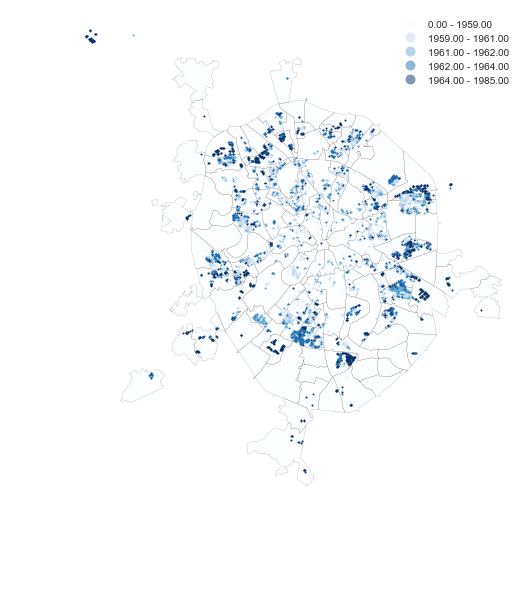

In [605]:
base = districts.plot(linewidth=0.1, facecolor=None, alpha=0.01, figsize=(12,10));
base.set_axis_off()
buildings.plot(column='year',ax=base, cmap='Blues', scheme='Quantiles',legend=True)

## Khrushchevki analysis

Let's explore features of our buildings - levels, houses type

In [4]:
buildings['levels_max'].value_counts()

5    7558
Name: levels_max, dtype: int64

Most of the houses considered are apartment houses 

In [259]:
buildings.house_type.value_counts()

apartment house                     7463
residential house terraced house      59
Spesialized housing stock             19
unknown                               17
Name: house_type, dtype: int64

In [260]:
buildings.critical_conditions.value_counts()

0.0    7547
1.0      11
Name: critical_conditions, dtype: int64

So among the houses only 11 houses are in critical conditions!

### Year of construction vs Technical service year

Khrushchevki first appeared in 1956. Since 1956 more than thousands new houses were built and the year 1964 had a peak of building activity. According to official statistics khrushchevki were built until 1985 and we can see that sharp down on the plot. 

As any house needs some repair works periodically and in our dataset we have such information of last service works made in the house. We see that most houses were recovered after 2010 year.

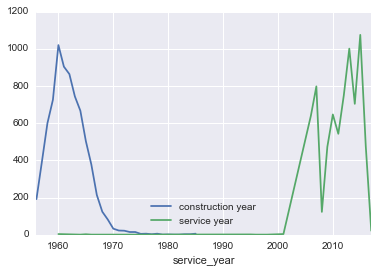

In [11]:
buildings.groupby('year').size().plot(kind='line',label='construction year',legend=True)
buildings.groupby('service_year').size().plot(kind='line',label='service year',legend=True)

As we know the date of last service and the consctruction year, we can check if there any correlation between these parameters and the actual house state. As we saw above only 11 houses officialy have critical conditions. The table below shows that we cannot extact any type of connection between the last service and critical conditions.

In [258]:
house_features = ['year','service_year', 'critical_conditions']
buildings[house_features].corr()

,year,service_year,critical_conditions
year,1.000000,0.027226,-0.015164
service_year,0.027226,1.000000,-0.056590
critical_conditions,-0.015164,-0.056590,1.000000


### Outdoor facilites

Some houses have got outdoor facilities such as playground or sportground. Let's see how many houses do have such facilities.

In [263]:
buildings.playground.value_counts()

1.0    3685
0.0    2955
Name: playground, dtype: int64

In [264]:
buildings.sportground.value_counts()

0.0    5881
1.0     682
Name: sportground, dtype: int64

In [293]:
houses_facilities = buildings[(buildings.playground == 1) & (buildings.sportground == 1)]

In [299]:
houses_facilities.shape

(589, 22)

Not many houses have got both type of facilities, there are only 589 houses with additional functions.

### Area

We can analyse how the house area varies from one house type to another

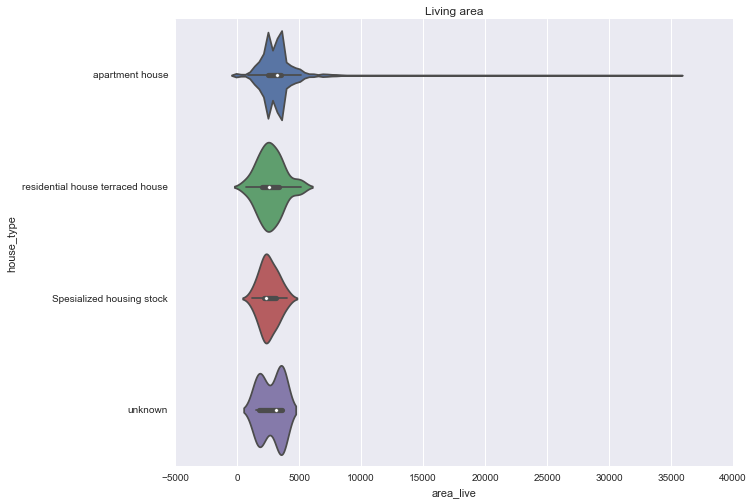

In [304]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(x='area_live',y='house_type', data=buildings,ax=ax,scale='width');
ax.set_title('Living area')


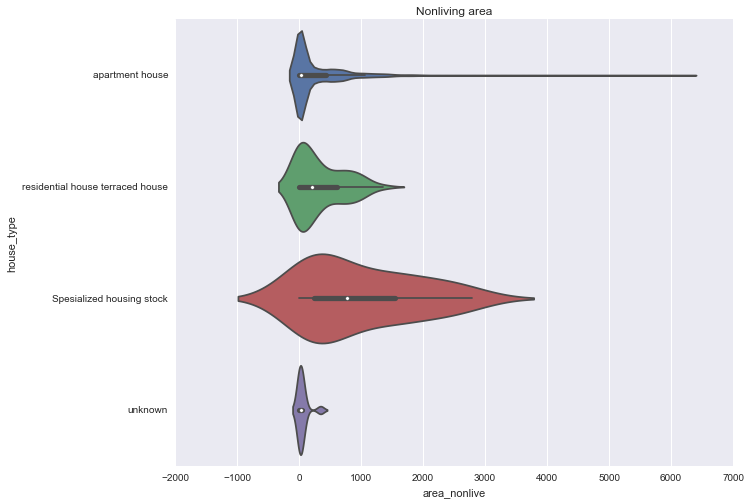

In [305]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(x='area_nonlive',y='house_type', data=buildings,ax=ax,scale='width');
ax.set_title('Nonliving area')

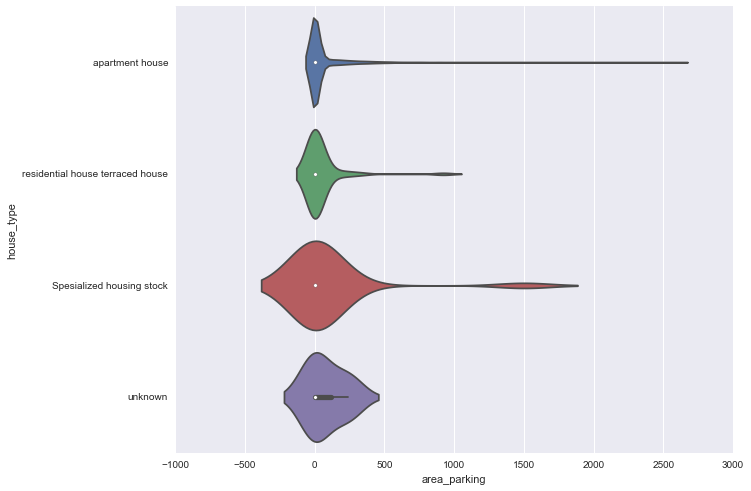

In [300]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(x='area_parking',y='house_type', data=buildings,ax=ax,scale='width')

### Moscow demography

In [582]:
population = ['TotalPopulationUnder18', 'TotalPopulationOfRetirementAge', 
              'TotalPopulationWorkingAge', '5et_ratio']

The raw count of people (i.e. number of retired persons) cannot tell us the actual distribution. The retired persons represent only some part of all people lived in a given district and it is crucial to keep in mind the underlying population. The map of raw counts will most likely simply display the overall pattern of the underlying population. 

In order to see the actual distribution of different group of people we need to **normalize** the data by the total district population. After the normalization the values range from 0 to 1 showing the intensity of people. We've got more accurate picture and can compare the districts between each other.

Let's analyze the population of people groups per district in Moscow. Consider the group of people which age is less than 18, population of retirement age and population of working age. We plot the normalized values. The map analysis shows that young population is mostly concentrated on borderland districts while the retired population is located in the centre. People of working group live most in the south part of Moscow coinciding with young people distribution.

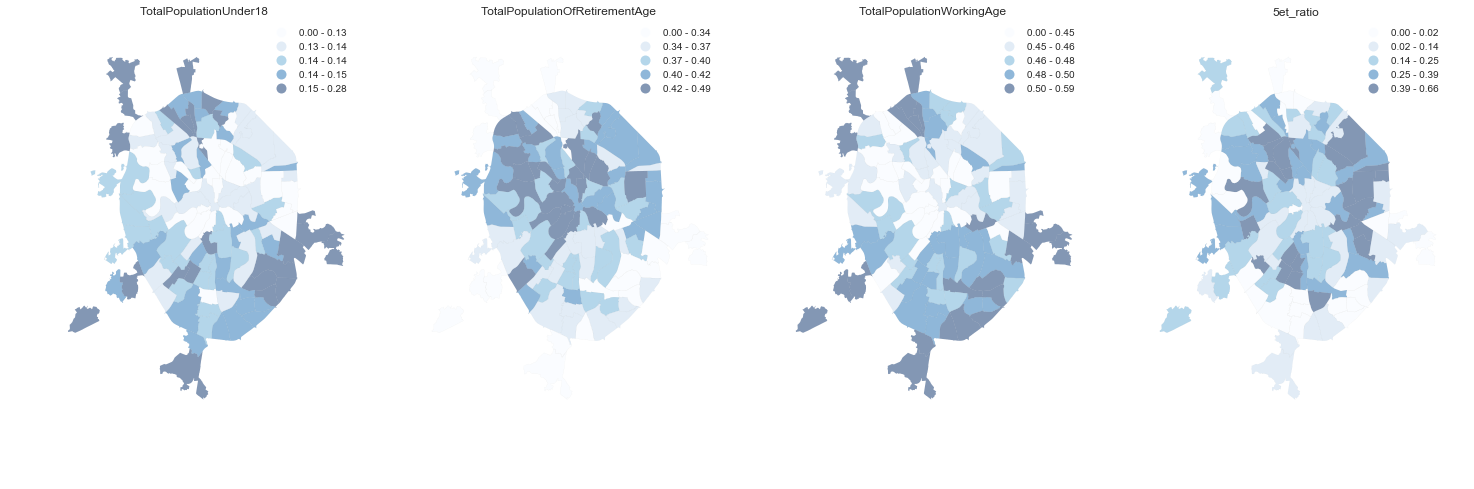

In [249]:
f, axs = plt.subplots(nrows=1, ncols=len(population), figsize=(25, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(population):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    districts.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0.01, cmap='Blues',legend=True)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Using pairplot we can understand the dependencies between variables and see its distribution. For example, it is easy to see the following relationship: the more number of retired population, the less the number of working population. And the more number of retired person lived in the area, the more number of khrushchevki houses.

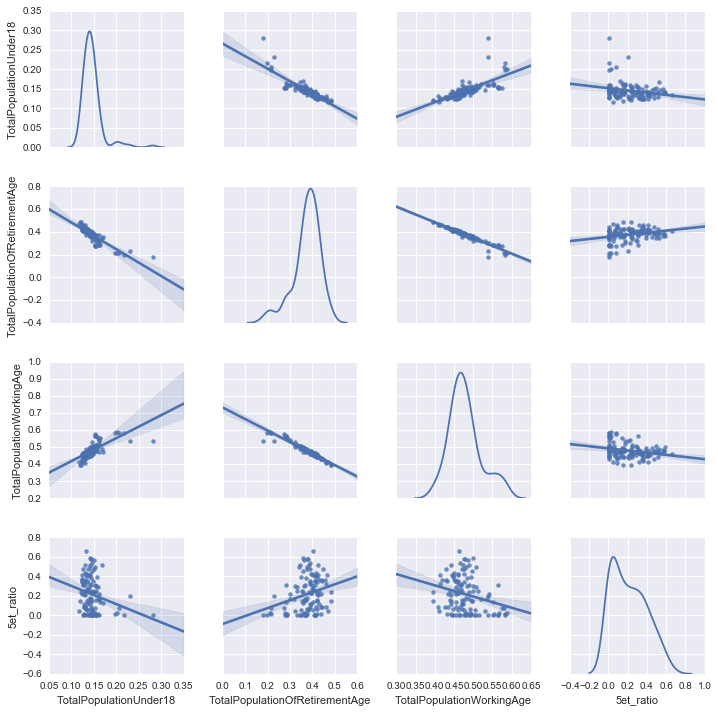

In [569]:
_ = sns.pairplot(districts[population], kind='reg', diag_kind='kde')

If the visual analysis is not enough we can simply extract the relationship in numeric value.

In [583]:
districts[population].corr()

,TotalPopulationUnder18,TotalPopulationOfRetirementAge,TotalPopulationWorkingAge,5et_ratio
TotalPopulationUnder18,1.000000,-0.869363,0.711664,-0.231414
TotalPopulationOfRetirementAge,-0.869363,1.000000,-0.964755,0.273119
TotalPopulationWorkingAge,0.711664,-0.964755,1.000000,-0.270069
5et_ratio,-0.231414,0.273119,-0.270069,1.000000


## Clustering

Based on demography data and buildings characteristics we can try to cluster the districts. The clustering will allow us to understand the spatial structure of districts through demography and housings. For that purpose we will try to apply Kmeans clustering alogrithms and plot the results.

In [589]:
kmeans = cluster.KMeans(n_clusters=5)

In [590]:
k5cls = kmeans.fit(districts[population].fillna(0))

In [591]:
k5cls.labels_

array([3, 0, 1, 1, 3, 2, 0, 1, 4, 4, 2, 0, 3, 1, 3, 0, 2, 3, 3, 1, 0, 1, 4,
       4, 1, 0, 3, 3, 0, 0, 0, 0, 0, 3, 1, 1, 1, 3, 2, 0, 1, 1, 3, 4, 3, 0,
       0, 0, 3, 4, 1, 3, 0, 1, 1, 1, 4, 3, 0, 1, 4, 1, 1, 0, 4, 1, 1, 1, 1,
       3, 3, 3, 0, 2, 0, 0, 3, 0, 0, 4, 4, 4, 2, 0, 1, 3, 3, 4, 4, 0, 1, 1,
       3, 1, 3, 2, 3, 3, 3, 2, 0, 3, 3, 2, 2, 3, 0, 1, 3, 0, 2, 2, 0, 2, 2,
       0, 2, 1, 1], dtype=int32)

In [592]:
districts['cluster'] = k5cls.labels_

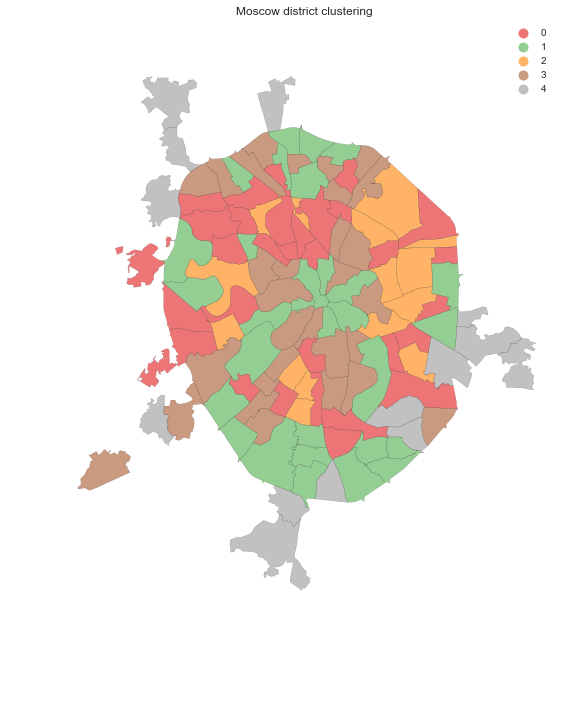

In [593]:
base = districts.plot(column='cluster',linewidth=0.1,  
                                 alpha=0.6,categorical=True, figsize=(16,12),legend=True);
base.set_axis_off()
base.set_title('Moscow district clustering')

### Exploring the nature of the categories

In [594]:
# Calculate the mean by group
k5means = districts_features.groupby('cluster')[population].mean()
# Show the table transposed (so it's not too wide)
k5means.T

cluster,0,1,2,3,4
TotalPopulationUnder18,0.150183,0.139253,0.154471,0.151112,0.142094
TotalPopulationOfRetirementAge,0.362070,0.396004,0.280416,0.339853,0.388254
TotalPopulationWorkingAge,0.487649,0.464626,0.563235,0.506200,0.469551
5et_ratio,0.044885,0.469489,0.004184,0.163382,0.255562


In [595]:
to_plot = districts.fillna(0).set_index('cluster')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[population]
# Display top of the table
to_plot.head()

,TotalPopulationUnder18,TotalPopulationOfRetirementAge,TotalPopulationWorkingAge,5et_ratio
cluster,,,,
3,0.160726,0.299326,0.539901,0.223404
0,0.140281,0.404503,0.455216,0.290385
1,0.144259,0.377062,0.478679,0.008621
1,0.116771,0.471837,0.411392,0.044025
3,0.126990,0.437459,0.435551,0.217391


In [596]:
to_plot = to_plot.stack()
to_plot.head()

cluster                                
3        TotalPopulationUnder18            0.160726
         TotalPopulationOfRetirementAge    0.299326
         TotalPopulationWorkingAge         0.539901
         5et_ratio                         0.223404
0        TotalPopulationUnder18            0.140281
dtype: float64

In [597]:
to_plot = to_plot.reset_index()
to_plot.head()

,cluster,level_1,0
0,3,TotalPopulationUnder18,0.160726
1,3,TotalPopulationOfRetirementAge,0.299326
2,3,TotalPopulationWorkingAge,0.539901
3,3,5et_ratio,0.223404
4,0,TotalPopulationUnder18,0.140281


In [598]:
to_plot = to_plot.rename(columns={'level_1': 'Feature', 0: 'Values'})
to_plot.head()

,cluster,Feature,Values
0,3,TotalPopulationUnder18,0.160726
1,3,TotalPopulationOfRetirementAge,0.299326
2,3,TotalPopulationWorkingAge,0.539901
3,3,5et_ratio,0.223404
4,0,TotalPopulationUnder18,0.140281


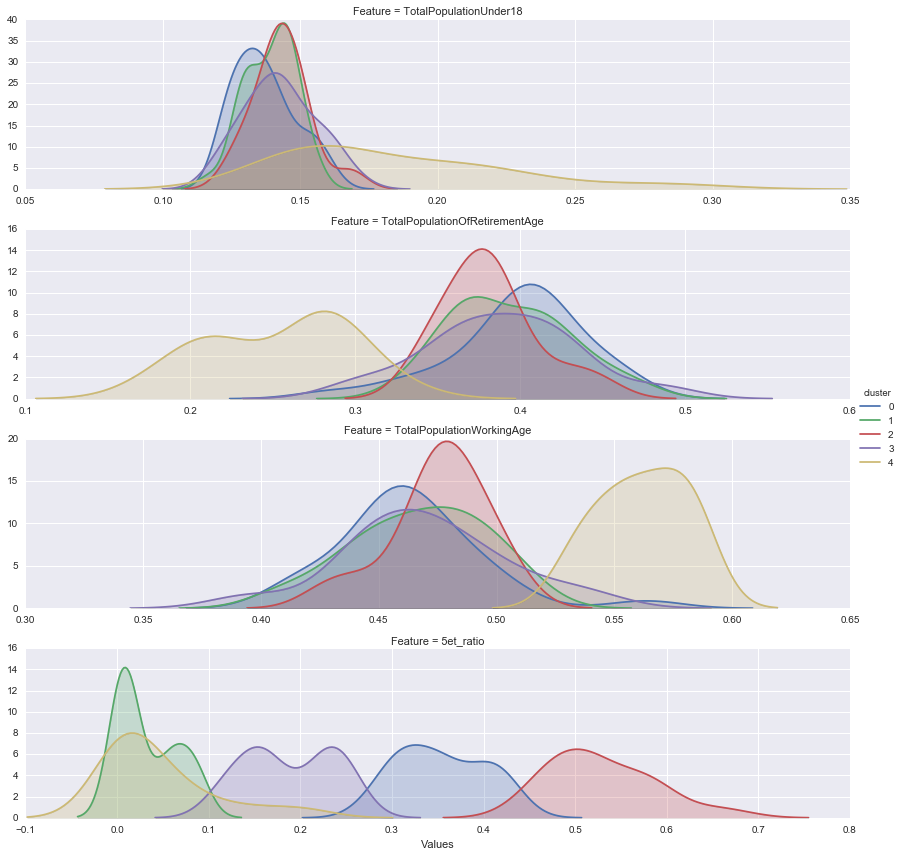

In [599]:
# Setup the facets
ratings_to_plot = to_plot[to_plot['Feature'].isin(population)]
facets = sns.FacetGrid(data=ratings_to_plot, row='Feature', hue='cluster', \
                  sharey=False, sharex=False, aspect=4)
# Build the plot as a `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

The plots for each cluster help us to interpret the results. Let's look at the cluster number 4. The districts grouped into cluster 4 are located on the border line of Moscow. The districts can be considered as "young" because there are districts recently joined Moscow. Mostly these districts have new housing so the percent of Khrushchevki is quite low and the histogram illustrates it well. The population feature distributions show that in a given cluster working people group is dominant and the number of retired people is the lowest among Moscow. 

Other clusters characterize by the high ratios of Khrushchevki(cluster 0 and 1) and the districts corresponded to clusters 

Compared to clusters 0 and 1, the third cluster does not have high Khrushchevki density(though it is bigger than in cluster 4) but the areas included in cluster show high population density among various people groups. 